In [1]:
%pylab inline
import scipy.constants as C
import numpy as np
from matplotlib import pyplot



Populating the interactive namespace from numpy and matplotlib


In [2]:
#members give hydrogen thermodynamic properties as a function of temperature in SI units
#presently using NIST properties without accounting for changes due to pressure,
#for an ideal gas, enthalpy is independent of pressure
#for an ideal gas, entropy decreases with pressure with a factor of -nR/P
#http://webbook.nist.gov/cgi/cbook.cgi?ID=C1333740&Type=JANAFG&Table=on#JANAFG
class Hydrogen:
    #returns constants for equations for use in internal functions
    def getConstants(T):
        if T < 298:
            raise ValueError('temperature out of range. must be greater than 298 K', T)
        elif T < 1000:
            A = 33.066178
            B = -11.363417
            C = 11.432816
            D = -2.772874
            E = -0.158558
            F = -9.980797
            G = 172.707974
            H = 0
        elif T < 2500:
            A = 18.563083
            B = 12.257357
            C = -2.859786
            D = 0.268238
            E = 1.977990
            F = -1.147438
            G = 156.288133
            H = 0
        elif T <= 6000:
            A = 43.413560
            B = -4.293079
            C = 1.272428
            D = -0.096876
            E = -20.533862
            F = -38.515158
            G = 162.081354
            H = 0
        else:
            raise ValueError('temperature out of range. must be less than 6000 K', T)
        
        return A, B, C, D, E, F, G, H
    
    #molecular mass in kilograms
    def MM():
        return 2.01588 * C.u
    
    #heat capacity ratio C_p / C_v
    def gamma(T):
        #can be considered constant since it varies very little with temperature and pressure
        return 1.40
    
    #heat capacity at standard pressure in J/mol*K
    def C_p(T):
        A, B, C, D, E, F, G, H = Hydrogen.getConstants(T)
        t = T / 1000
        return  A + B*t + C*t**2 + D*t**3 + E/t**2
    
    #constant volume heat capacity in J/mol*K
    def C_v(T):
        return Hydrogen.C_p(T) / Hydrogen.gamma(T)
        
    #enthalpy relative to STP in J/mol*K
    def H(T):
        A, B, C, D, E, F, G, H = Hydrogen.getConstants(T)
        t = T / 1000
        return A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    
    #standard entropy in J/mol*K
    def S(T):
        A, B, C, D, E, F, G, H = Hydrogen.getConstants(T)
        t = T / 1000
        return A*log(t) + B*t + C*t**2/2 + D*t**3/3 - E/(2*t**2) + G
        
    #returns false if a value doesn't match the values in the NIST table
    def runTests():
        tests = [
        [298.0, 28.84, 130.7, -0.00],
        [300.0, 28.85, 130.9, 0.05],
        [700.0, 29.44, 155.6, 11.75],
        [800.0, 29.62, 159.5, 14.70],
        [1000., 30.21, 166.2, 20.68],
        [1300., 31.42, 174.3, 29.92],
        [1700., 33.14, 182.9, 42.83],
        [2100., 34.62, 190.1, 56.40],
        [3200., 37.53, 205.3, 96.20],
        [6000., 41.97, 230.3, 208.3]
        ]
        
        passed = True
        
        for test in tests:
            T = test[0]
            if abs(Hydrogen.C_p(T) - test[1]) > 0.01:
                print(test, 'C_p')
                passed = False
            if abs(Hydrogen.S(T) - test[2]) > 0.1:
                print(test, 'S')
                passed = False
            if abs(Hydrogen.H(T) - test[3]) > 0.05:
                print(test, 'H')
                passed = False
            if abs(Hydrogen.gamma(T) - 7/5) > 0.02: #7/5 is the theoretical value for a diatomic gas
                print(test, 'gamma')
                passed = False
            if abs(Hydrogen.gamma(T) - Hydrogen.C_p(T) / Hydrogen.C_v(T)) > 0.0001:
                print(test, 'C_v')
                passed = False
            
        return passed
        

In [3]:
H2 = Hydrogen

testPassed = H2.runTests()

if testPassed:
    print("tests passed for hydrogen properties class")
else:
    print("TEST FAILED. THIS IS BAD. FIX THIS.")

tests passed for hydrogen properties class


In [4]:
######### adjustable parameters #########

power = 230e6 #core power in watts
m_dot = 6 #mass flow rate in kg / s
T_0 = 500 #inlet temperatur in kelvins
P_0 = 100e3 #inlet pressure in pascals

#########################################

rho_0 = H2.MM() * P_0 / (C.k * T_0) #inlet density in kg/m^3 from ideal gas law
v_0 = m_dot / rho_0   #inlet velocity in m/s
Ma_0 = (v_0**2 * H2.MM() / (H2.gamma(T_0) * C.k * T_0))**0.5 #inital Mach number using ideal gas speed of sound

Q = [0] #heat added up  to a point
T = [T_0] #temperature at a point
v = [v_0] #velocity at a point
rho = [rho_0] #density at a point
Ma = [Ma_0] #mach number at a point

N = int(1e3) #number of slices; higher N means finer results

delta_q = power / m_dot #total heat per unit mass added in J/kg
dQ = delta_q / N #heat added per unit mass at each step in J/kg

#for each slice of coolant in the channel, add a constant amount of heat
#and apply equations for Rayleigh flow to update temperature and velocity
#Rayleigh flow assumes ideal gas, no friction, constant channel area

reachedMachOne = (Ma[-1] == 1)
i = 0
while i < N and not reachedMachOne:
    i += 1
    if i % 10**int(log(N/3)/log(10)) == 0: #print progress
        print(i)
    
    C_p = H2.C_p(T[-1]) / H2.MM() / C.N_A #C_p in per kg units instead of per mol
    
    Mach_sq = v[-1]**2 * H2.MM() / (H2.gamma(T[-1]) * C.k * T[-1])
    dv = v[-1] * dQ / (C_p * T[-1]) / (1 - Mach_sq) #Eq. 11.121 from Munson Fluid Dynamics Ch. 11.5.2
    dT = (dQ - v[-1]*dv) / C_p #heat not contributing to velocity goes into enthalpy
    
    #update values
    Ma.append(Mach_sq**0.5)
    Q.append(Q[-1] + dQ)
    T.append(T[-1] + dT)
    v.append(v[-1] + dv)
    #using the fact that rho * v is constant by mass flow rate continuity
    rho.append(rho[-1] * v[-2] / v[-1]) #v[-1] is the updated velocity here, v[-2] is v before the update
    
    #check if further heat addition is possible, otherwise nothing can change; Rayleigh flow cannot cross Mach 1
    if (Ma[-1] < 1) != (Ma[-2] < 1):
        reachedMachOne = True
        
if reachedMachOne:
    print("reached Mach 1 at step {0} out of {1}".format(i, N))
    Ma.pop() #remove bad data
    Q.pop()
    T.pop()
    v.pop()
    rho.pop()


100
200
300
400
500
600
700
800
900
1000


[500, 502.63522529124776, 505.2702959308256, 507.90521218985066, 510.5399741741999]
[2826.556425312308, 2828.640542213204, 2830.7243601206574, 2832.807879409429, 2834.8911004527486]


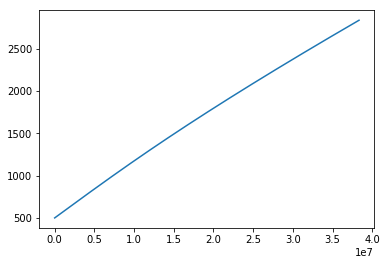

In [5]:
plot(Q, T)

print(T[:5])
print(T[-5:])

[123.73444644900628, 124.39145271440846, 125.04847232304681, 125.70550534550368, 126.36255181108321]
[724.7444751938618, 725.3025109534829, 725.8605038710218, 726.4184540374033, 726.976361543166]


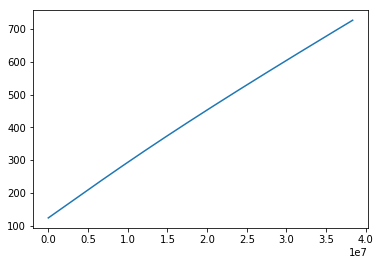

In [6]:
plot(Q, v)


print(v[:5])
print(v[-5:])

[0.048490943081664274, 0.04823482537643047, 0.04798139384301924, 0.047730606416233716, 0.04748242192014472]
[0.008278779908456801, 0.008272410352078348, 0.008266051077310238, 0.008259702058300232, 0.008253363269286641]


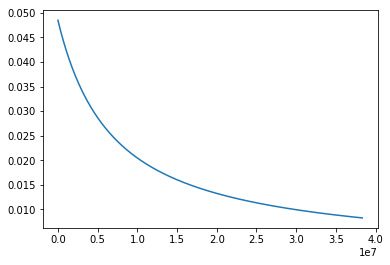

In [7]:
plot(Q, rho)


print(rho[:5])
print(rho[-5:])

[0.07282104673660325, 0.07282104673660325, 0.07301555300612858, 0.07320956163095967, 0.07340307658042163]
[0.17932177316637762, 0.17939378094217814, 0.17946575889016686, 0.17953770705726738, 0.17960962549026635]


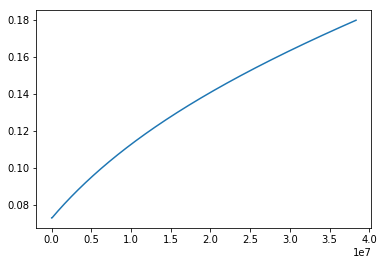

In [8]:
plot(Q, Ma)


print(Ma[:5])
print(Ma[-5:])